# Part 2
Original Competition: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
Using the file: jigsaw-toxic-comment-classification-challenge.zip
The .zip file contains the Jigsaw Toxic Comment Classification dataset as provided in the original
Kaggle competition. Data is organized as zip files containing .csv files. The training data is
organized by ID, text, label.
Content Warning: The dataset contains text that may be considered profane, vulgar, or
offensive.

###Step 1 : Load the dataset
###Step 2 : Preprocess the data as you see fit
###Step 3 : Utilize a model implementing a Natural Language Processing strategy
###Step 4 : Train your model
###Step 5 : Display the results of your model on the Test dataset by showing the predicted labels against their true labels

# Importing all the required libraries

In [47]:
import pandas as pd
import numpy as np
import re
import io
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase
!pip install talos
from tqdm import tqdm_notebook
import itertools

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# loading the data
train=pd.read_csv('train.csv')

In [50]:
# Top 5 records of the data
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [51]:
# loading the data
test=pd.read_csv('test.csv')

In [52]:
# Top 5 records of the data
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [53]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [54]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [55]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

# Data Pre-processing

* Text Normalization
* Removing Characters & Repeated Characters in Text
* Converting data to lower-case
* Removing Numbers from data
* Removing Punctuation, Whitespaces,spaces in between words & "\n".
* Removing Non-english characters

In [56]:
RE_PATTERNS = {
    ' american ':['amerikan'],
    ' adolf ':['adolf'],
    ' hitler ':['hitler'],
    ' fuck':['(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'],
    ' ass ':['[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'],
    ' ass hole ':[' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'],
    ' bitch ':['b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'],
    ' bastard ':['ba[s|z]+t[e|a]+rd'],
    ' trans gender':['transgender'],
    ' gay ':['gay'],
    ' cock ':['[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'],
    ' dick ':[' dick[^aeiou]', 'deek', 'd i c k', 'dik'],
    ' suck ':['sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'],
    ' cunt ':['cunt', 'c u n t'],
    ' bull shit ':['bullsh\*t', 'bull\$hit'],
    ' homo sex ual':['homosexual'],
    ' jerk ':['jerk'],
    ' idiot ':['i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'],
    ' dumb ':['(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'],
    ' shit ':['shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'],
    ' shit hole ':['shythole'],
    ' retard ':['returd', 'retad', 'retard', 'wiktard', 'wikitud'],
    ' rape ':[' raped'],
    ' dumb ass':['dumbass', 'dubass'],
    ' ass head':['butthead'],
    ' sex ':['sexy', 's3x', 'sexuality'],
    ' nigger ':['nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'],
    ' shut the fuck up':['stfu', 'st*u'],
    ' pussy ':['pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'],
    ' faggot ':['faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',],
    ' mother fucker':[' motha ', ' motha f', ' mother f', 'motherucker',],
    ' whore ':['wh\*\*\*', 'w h o r e'],
    ' fucking ':['f*$%-ing'],}

In [57]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):
  if is_lower:
    text=text.lower()
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)
  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text)
  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text

# Cleaning the TEST data

In [58]:
test['comment_text'][18]

":: Wallamoose was changing the cited material to say things the original source did not say. In response to his objections, I modified the article as we went along. I was not just reverting him. I repeatedly asked him to use the talk page. I've been trying to add to the article for a long time.  It's so thin on content. This is wrong."

In [59]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][18]

' wallamoose was changing the cited material to say things the original source did not say in response to his objections i modified the article as we went along i was not just reverting him i repeatedly asked him to use the talk page i ve been trying to add to the article for a long time it s so thin on content this is wrong '

# Cleaning the TRAIN data

In [60]:
train['comment_text'][6001]

"Re:Miley Cyrus' death \n\nAh, we meet again! I've added a 3RR report for this user, as it's been 4 reverts so far. It's not just him/her, though, and not just here. I can't find anything about this being true, though."

In [61]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][6001]

're miley cyrus death ah we meet again i ve added a rr report for this user as it s been reverts so far it s not just him her though and not just here i can t find anything about this being true though '

### Lemmatization :
* process of grouping together different inflected forms of the same word.

In [62]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [63]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  return str(output.strip())

## Lemmatize test data

In [ ]:
lemmatized_test_data = []
for line in tqdm_notebook(comments_test, total=len(comments_test)):
    lemmatized_test_data.append(lemma(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

In [ ]:
lemmatized_test_data[153154]

'shame on you all you want to speak about gay s and not about romanian'

## Lemmatize train data

In [ ]:
lemmatized_train_data = []
for line in tqdm_notebook(comments_train, total=159571):
    lemmatized_train_data.append(lemma(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
lemmatized_train_data[15258]

'content relativeto importance visual style i ll to see what i can do'

### Removing Stopwords
* One of the most commonly used preprocessing steps across different NLP applications.

In [ ]:
stopword_list=STOP_WORDS

In [ ]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)
dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [ ]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [64]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Completed!!")

Completed!!


In [69]:
# Looking out other terms that we might require in STOP_WORDS
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word
  else:
    output=data
  return str(output.strip())

In [ ]:
potential_stopwords = []

for line in tqdm_notebook(lemmatized_train_data, total=159571):
    potential_stopwords.append(search_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
len(potential_stopwords)

159571

In [ ]:
# forming a single string out of every sentence in the list
def string_combine_a(stopword):
  final_a=""
  for item in range(39893):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(39893,79785):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(79785,119678):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(119678,159571):
    final_d=final_d+" "+stopword[item]
  return final_d

In [ ]:
total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

In [ ]:
# determining how many words are in each of the four strings
def word_count(str):
    counts = dict()
    words = str.split()
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

In [ ]:
total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

In [ ]:
# Converting Dataframe Dictionaries
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

In [ ]:
# Obtaining the result of a dataframe sorted downward
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

In [ ]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))


In [ ]:
print(common_potential_stopwords)

['source', 'find', 'fact', 'mean', 'talk', 'think', 'need', 'write', 'help', 'point', 'add', 'know', 'information', 'image', 'wikipedia', 'like', 'time', 'block', 'look', 'edit', 'use', 'user', 'delete', 'way', 'comment', 'page', 'good', 'want', 'deletion', 'change', 'editor', 'list', 'reference', 'doe', 'people', 'link', 'try', 'section', 'new', 'thing', 'read', 'thank', 'remove', 'question', 'don', 'fuck', 'work', 'article']


In [ ]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']


In [ ]:
# adding the words that were recovered above to the list of stopwords
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!


In [ ]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text
  return str(output.strip())

In [ ]:
processed_train_data = []
for line in tqdm_notebook(lemmatized_train_data, total=159571):
    processed_train_data.append(remove_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
processed_train_data[1558]

'esports category ask category electronic sport game category esports game general convention catname avoid abbreviation topic category correspond article case electronic sport'

In [ ]:
# Eliminating Terminologies from Test Data
processed_test_data = []
for line in tqdm_notebook(lemmatized_test_data, total=153164):
    processed_test_data.append(remove_stopwords(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

In [ ]:
processed_test_data[9875]

'barnstar style background color fdffe border solid fceb rowspan style vertical align middle pad style font size large pad height original barnstar style vertical align middle pad hate fuck fuck edit best regard alex'

# Model Building

In [ ]:
max_features=100000
maxpadlen = 200
val_split = 0.2
embedding_dim_fasttext = 300

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [ ]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  148917


In [ ]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [ ]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  116   578    11 32199   239   192    11 32199   239    90    11   579
    11   116   366   578     1  1082   116   338  5356   116   119    11
   387   269   366   578    11     1  1341   116    11   387     2    32
   116   578   192   116   172    46    84   579   116   578    11     2
   488   105    10  1087   403  1073    11  2401   489    36   116    11
   192   407   366     9   255   192   242   150   109    18    19    29
   172    77    19     3   257  4540     4    11 32199   239   192    11
 32199   239    90   171   387   312    68   579    34    44    77   423
  1550    34   171     8   579  1268    77  1638   134    10   134  4671
   134    94    44   565  1255    17    77  1338   118   134  1577    77
  1134     4   507    77   434    31   171    68    34   168  2207   449
    31   315  1529    70   172   236   150   116    31    31    11    77
    31   116    11    77    31    77    31   192   171    46    84   579
     4    31   171   192    

In [ ]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [ ]:
X_t = X_t[indices]
labels = y[indices]

In [ ]:
# Dividing Data into Validation and Training Sets
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [ ]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12148  1292  6777   388  6328  1153]
validation:  [3146  303 1672   90 1549  252]


In [ ]:
# Adding Quick Text
embeddings_index_fasttext = {}
f = open('/content/drive/MyDrive/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [ ]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print(" Completed!")

 Completed!


## Talos Grid Search model creation for LSTM model

In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):
  inp=Input(shape=(maxpadlen, ),dtype='int32')
  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)
  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  x = GlobalMaxPool1D()(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  x = Dropout(params['dropout'])(x)
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)
  model = Model(inputs=inp, outputs=preds)
  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))
  return model_info, model

In [ ]:
p={
    'output_count_lstm': [40],
    'output_count_dense': [30],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']}

In [ ]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/18 [00:00<?, ?it/s]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 9ms/step - loss: 0.0651 - accuracy: 0.9385 - val_loss: 0.0517 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0497 - accuracy: 0.9910 - val_loss: 0.0488 - val_accuracy: 0.9941


  6%|▌         | 1/18 [01:21<23:00, 81.22s/it]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0718 - accuracy: 0.8938 - val_loss: 0.0534 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0524 - accuracy: 0.9853 - val_loss: 0.0506 - val_accuracy: 0.9941


 11%|█         | 2/18 [02:37<20:53, 78.32s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0634 - accuracy: 0.9343 - val_loss: 0.0504 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0492 - accuracy: 0.9783 - val_loss: 0.0480 - val_accuracy: 0.9940


 17%|█▋        | 3/18 [04:02<20:22, 81.52s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0665 - accuracy: 0.9477 - val_loss: 0.0514 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0514 - accuracy: 0.9923 - val_loss: 0.0500 - val_accuracy: 0.9941


 22%|██▏       | 4/18 [05:18<18:28, 79.15s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0655 - accuracy: 0.9432 - val_loss: 0.0500 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0490 - accuracy: 0.9851 - val_loss: 0.0475 - val_accuracy: 0.9940


 28%|██▊       | 5/18 [06:33<16:48, 77.59s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0682 - accuracy: 0.9083 - val_loss: 0.0507 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 35s 9ms/step - loss: 0.0507 - accuracy: 0.9888 - val_loss: 0.0496 - val_accuracy: 0.9941


 33%|███▎      | 6/18 [07:47<15:18, 76.57s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0651 - accuracy: 0.8930 - val_loss: 0.0511 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 38s 10ms/step - loss: 0.0502 - accuracy: 0.9803 - val_loss: 0.0484 - val_accuracy: 0.9937


 39%|███▉      | 7/18 [09:07<14:13, 77.56s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0675 - accuracy: 0.8810 - val_loss: 0.0544 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0515 - accuracy: 0.9895 - val_loss: 0.0488 - val_accuracy: 0.9941


 44%|████▍     | 8/18 [10:25<12:58, 77.84s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0635 - accuracy: 0.9571 - val_loss: 0.0504 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0491 - accuracy: 0.9856 - val_loss: 0.0497 - val_accuracy: 0.9941


 50%|█████     | 9/18 [11:43<11:41, 77.91s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0662 - accuracy: 0.9350 - val_loss: 0.0512 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0514 - accuracy: 0.9914 - val_loss: 0.0498 - val_accuracy: 0.9941


 56%|█████▌    | 10/18 [13:09<10:41, 80.18s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0616 - accuracy: 0.9584 - val_loss: 0.0502 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 37s 9ms/step - loss: 0.0491 - accuracy: 0.9916 - val_loss: 0.0479 - val_accuracy: 0.9941


 61%|██████    | 11/18 [14:27<09:17, 79.61s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 40s 9ms/step - loss: 0.0666 - accuracy: 0.9057 - val_loss: 0.0543 - val_accuracy: 0.9935
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0508 - accuracy: 0.9755 - val_loss: 0.0482 - val_accuracy: 0.9941


 67%|██████▋   | 12/18 [15:45<07:54, 79.06s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0624 - accuracy: 0.9251 - val_loss: 0.0508 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0489 - accuracy: 0.9857 - val_loss: 0.0503 - val_accuracy: 0.9938


 72%|███████▏  | 13/18 [17:05<06:36, 79.30s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0680 - accuracy: 0.9139 - val_loss: 0.0524 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0523 - accuracy: 0.9828 - val_loss: 0.0502 - val_accuracy: 0.9941


 78%|███████▊  | 14/18 [18:25<05:18, 79.53s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0626 - accuracy: 0.9460 - val_loss: 0.0507 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0488 - accuracy: 0.9796 - val_loss: 0.0475 - val_accuracy: 0.9940


 83%|████████▎ | 15/18 [19:45<03:59, 79.82s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0652 - accuracy: 0.9158 - val_loss: 0.0511 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0515 - accuracy: 0.9884 - val_loss: 0.0486 - val_accuracy: 0.9941


 89%|████████▉ | 16/18 [21:11<02:43, 81.51s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0616 - accuracy: 0.9491 - val_loss: 0.0502 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 38s 9ms/step - loss: 0.0481 - accuracy: 0.9840 - val_loss: 0.0484 - val_accuracy: 0.9941


 94%|█████████▍| 17/18 [22:31<01:21, 81.15s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0640 - accuracy: 0.9060 - val_loss: 0.0508 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 38s 10ms/step - loss: 0.0502 - accuracy: 0.9784 - val_loss: 0.0483 - val_accuracy: 0.9941


100%|██████████| 18/18 [23:51<00:00, 79.54s/it]


In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

1

In [ ]:
analyze_object = talos.Analyze(scan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[84.3994562625885, 2, 'adam', 'relu', 'sigmoid',
        '04/27/23-081420', 0.2, 32, 40, 50, '04/27/23-081255', 2, 0],
       [75.45785784721375, 2, 'adam', 'relu', 'sigmoid',
        '04/27/23-080348', 0.2, 32, 30, 40, '04/27/23-080233', 2, 1],
       [79.4372923374176, 2, 'adam', 'relu', 'sigmoid',
        '04/27/23-082342', 0.1, 32, 50, 60, '04/27/23-082222', 2, 2],
       [84.55896711349487, 2, 'adam', 'relu', 'sigmoid',
        '04/27/23-082222', 0.2, 32, 40, 60, '04/27/23-082057', 2, 3],
       [79.19055008888245, 2, 'adam', 'relu', 'sigmoid',
        '04/27/23-081936', 0.2, 32, 30, 60, '04/27/23-081816', 2, 4],
       [76.95599150657654, 2, 'adam', 'relu', 'sigmoid',
        '04/27/23-081656', 0.2, 32, 50, 50, '04/27/23-081539', 2, 5],
       [77.46904993057251, 2, 'adam', 'relu', 'sigmoid',
        '04/27/23-081538', 0.1, 32, 50, 50, '04/27/23-081420', 2, 6],
       [79.51784896850586, 2, 'adam', 'relu', 'sigmoid',
        '04/27/23-082502', 0.2, 32, 50, 60, '04/27/23-08

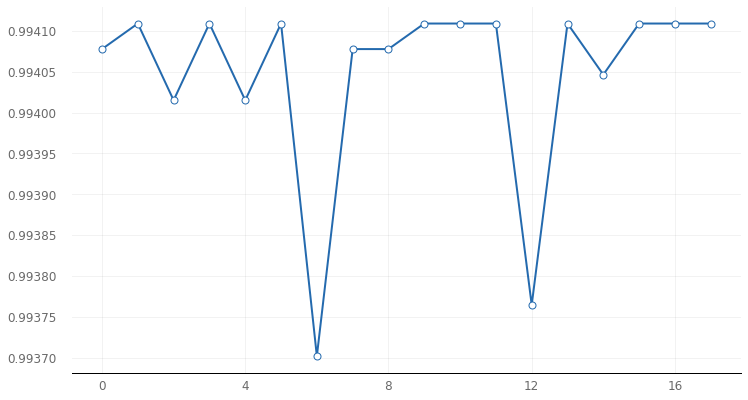

In [ ]:
analyze_object.plot_line('val_accuracy')

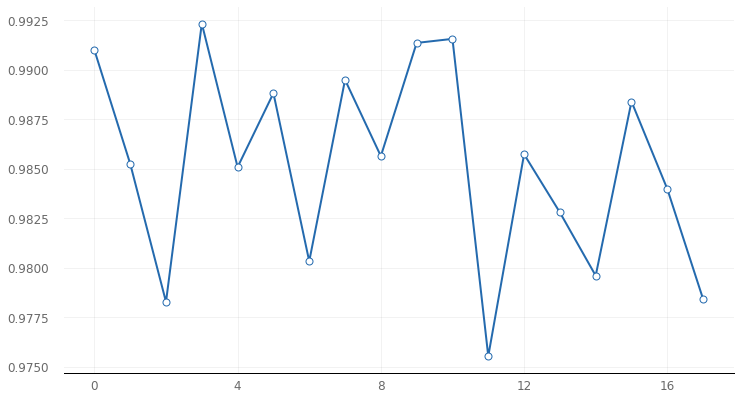

In [ ]:
analyze_object.plot_line('accuracy')

# Talos Grid Search for LSTM-CNN Model


In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):
  inp=Input(shape=(maxpadlen, ),dtype='int32')
  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)
  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  x = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], padding='same', activation='relu', kernel_initializer='he_uniform')(x)
  x = MaxPooling1D(params['pool_size'])(x)
  x = GlobalMaxPool1D()(x)
  x = BatchNormalization()(x)
  x = Dense(params['output_1_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(params['output_2_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  x = Dropout(params['dropout'])(x)
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)
  model = Model(inputs=inp, outputs=preds)
  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))
  return model_info, model

In [ ]:
p={
    'output_count_lstm': [50,60],
    'output_1_count_dense': [40,50],
    'output_2_count_dense': [30,40],
    'filters' : [64],
    'kernel_size' : [3],
    'batch_size': [32],
    'pool_size': [3],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']}

In [ ]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/16 [00:00<?, ?it/s]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 11ms/step - loss: 0.0680 - accuracy: 0.8802 - val_loss: 0.0524 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0522 - accuracy: 0.9812 - val_loss: 0.0498 - val_accuracy: 0.9931


  6%|▋         | 1/16 [02:26<36:30, 146.00s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0743 - accuracy: 0.8934 - val_loss: 0.0572 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0547 - accuracy: 0.9887 - val_loss: 0.0532 - val_accuracy: 0.9941


 12%|█▎        | 2/16 [03:56<26:24, 113.18s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0654 - accuracy: 0.9256 - val_loss: 0.0534 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0530 - accuracy: 0.9891 - val_loss: 0.0515 - val_accuracy: 0.9936


 19%|█▉        | 3/16 [05:25<22:11, 102.43s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0685 - accuracy: 0.8519 - val_loss: 0.0556 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0542 - accuracy: 0.9650 - val_loss: 0.0499 - val_accuracy: 0.9941


 25%|██▌       | 4/16 [06:54<19:25, 97.15s/it] 

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0671 - accuracy: 0.8925 - val_loss: 0.0524 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0525 - accuracy: 0.9786 - val_loss: 0.0498 - val_accuracy: 0.9863


 31%|███▏      | 5/16 [08:24<17:17, 94.36s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0677 - accuracy: 0.9190 - val_loss: 0.0634 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0544 - accuracy: 0.9886 - val_loss: 0.0544 - val_accuracy: 0.9941


 38%|███▊      | 6/16 [09:53<15:25, 92.60s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0653 - accuracy: 0.8436 - val_loss: 0.0564 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0525 - accuracy: 0.9595 - val_loss: 0.0502 - val_accuracy: 0.8660


 44%|████▍     | 7/16 [11:22<13:43, 91.52s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0682 - accuracy: 0.9146 - val_loss: 0.0538 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0541 - accuracy: 0.9683 - val_loss: 0.0557 - val_accuracy: 0.9940


 50%|█████     | 8/16 [12:51<12:05, 90.70s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 50s 12ms/step - loss: 0.0663 - accuracy: 0.9194 - val_loss: 0.0578 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0528 - accuracy: 0.9815 - val_loss: 0.0500 - val_accuracy: 0.9935


 56%|█████▋    | 9/16 [15:17<12:36, 108.02s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0710 - accuracy: 0.8786 - val_loss: 0.0545 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0548 - accuracy: 0.9849 - val_loss: 0.0509 - val_accuracy: 0.9941


 62%|██████▎   | 10/16 [16:48<10:16, 102.68s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0661 - accuracy: 0.9047 - val_loss: 0.0582 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0523 - accuracy: 0.9606 - val_loss: 0.0499 - val_accuracy: 0.9939


 69%|██████▉   | 11/16 [19:14<09:39, 115.95s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0736 - accuracy: 0.9111 - val_loss: 0.0633 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0546 - accuracy: 0.9884 - val_loss: 0.0566 - val_accuracy: 0.9941


 75%|███████▌  | 12/16 [21:40<08:20, 125.13s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0686 - accuracy: 0.8873 - val_loss: 0.0827 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0528 - accuracy: 0.9732 - val_loss: 0.0508 - val_accuracy: 0.9940


 81%|████████▏ | 13/16 [23:11<05:44, 114.82s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0710 - accuracy: 0.8461 - val_loss: 0.0563 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0543 - accuracy: 0.9809 - val_loss: 0.0506 - val_accuracy: 0.9941


 88%|████████▊ | 14/16 [24:42<03:35, 107.55s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0671 - accuracy: 0.8977 - val_loss: 0.0578 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0526 - accuracy: 0.9695 - val_loss: 0.0547 - val_accuracy: 0.9931


 94%|█████████▍| 15/16 [27:08<01:59, 119.18s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0688 - accuracy: 0.8856 - val_loss: 0.0563 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0543 - accuracy: 0.9832 - val_loss: 0.0519 - val_accuracy: 0.9941


100%|██████████| 16/16 [28:40<00:00, 107.50s/it]


In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

1

In [ ]:
scan_results.data[8:9]

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,output_count_lstm,output_1_count_dense,...,filters,kernel_size,batch_size,pool_size,epochs,optimizer,activation,last_activation,dropout,loss
8,04/27/23-083921,04/27/23-084146,145.092358,2,0.052795,0.981536,0.050041,0.993482,60,40,...,64,3,32,3,2,adam,relu,sigmoid,0.1,binary_crossentropy


In [ ]:
analyze_object = talos.Analyze(scan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[89.31657934188843, 40, 30, 2, 3, 64, 'adam', 'relu', 3,
        'sigmoid', '04/27/23-083025', 0.2, 32, 50, '04/27/23-082855', 2,
        0],
       [88.1637864112854, 40, 40, 2, 3, 64, 'adam', 'relu', 3, 'sigmoid',
        '04/27/23-083323', 0.2, 32, 50, '04/27/23-083155', 2, 1],
       [89.74693489074707, 40, 30, 2, 3, 64, 'adam', 'relu', 3,
        'sigmoid', '04/27/23-084317', 0.2, 32, 60, '04/27/23-084147', 2,
        2],
       [145.15335988998413, 40, 40, 2, 3, 64, 'adam', 'relu', 3,
        'sigmoid', '04/27/23-084809', 0.2, 32, 60, '04/27/23-084544', 2,
        3],
       [89.7519359588623, 50, 30, 2, 3, 64, 'adam', 'relu', 3, 'sigmoid',
        '04/27/23-085111', 0.2, 32, 60, '04/27/23-084941', 2, 4],
       [90.36681032180786, 50, 40, 2, 3, 64, 'adam', 'relu', 3,
        'sigmoid', '04/27/23-085508', 0.2, 32, 60, '04/27/23-085338', 2,
        5],
       [88.2356424331665, 50, 30, 2, 3, 64, 'adam', 'relu', 3, 'sigmoid',
        '04/27/23-083622', 0.2, 32, 50, '04/27/23

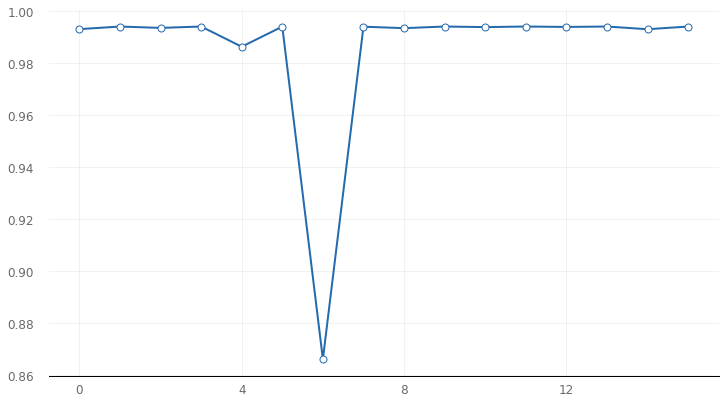

In [ ]:
analyze_object.plot_line('val_accuracy')

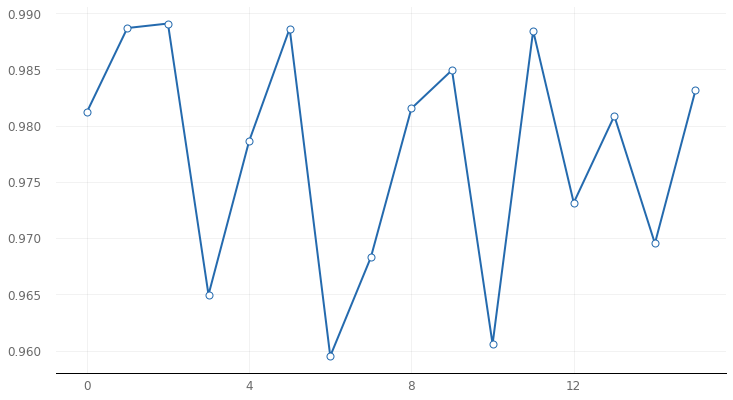

In [ ]:
analyze_object.plot_line('accuracy')

## Model LSTM: training the models with optimal parameters

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44675400  
                                                                 
 lstm_layer (LSTM)           (None, 200, 40)           54560     
                                                                 
 global_max_pooling1d (Globa  (None, 40)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                             

In [ ]:
model_info_1=model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 39s 9ms/step - loss: 0.0638 - accuracy: 0.9045 - val_loss: 0.0512 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 36s 9ms/step - loss: 0.0502 - accuracy: 0.9887 - val_loss: 0.0492 - val_accuracy: 0.9941


# Model LSTM-CNN

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_2 = Model(inputs=inp, outputs=preds)
model_2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44675400  
                                                                 
 lstm_layer (LSTM)           (None, 200, 50)           70200     
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           9664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 66, 64)           0         
 )                                                               
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                          

In [ ]:
model_info_2=model_2.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0690 - accuracy: 0.8617 - val_loss: 0.0643 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0545 - accuracy: 0.9677 - val_loss: 0.0504 - val_accuracy: 0.9941


# LSTM Plots for Loss & Accuracy

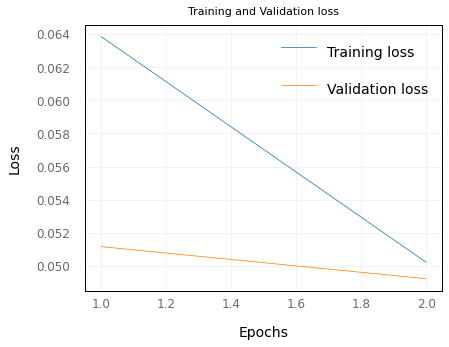

In [ ]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

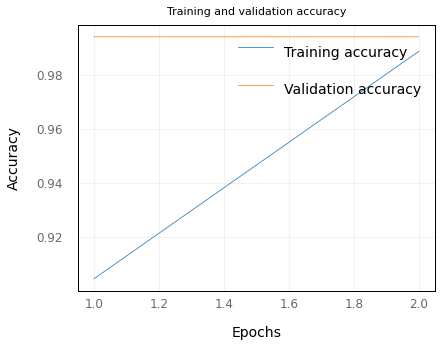

In [ ]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Model LSTM-CNN
Loss & Accuracy Plots

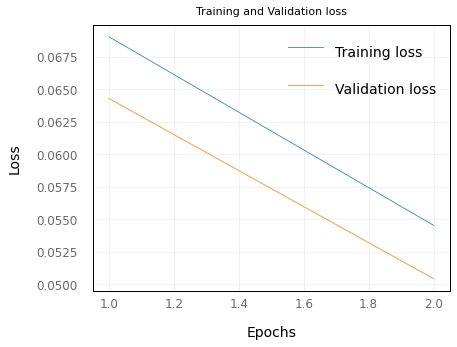

In [ ]:
loss = model_info_2.history['loss']
val_loss = model_info_2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

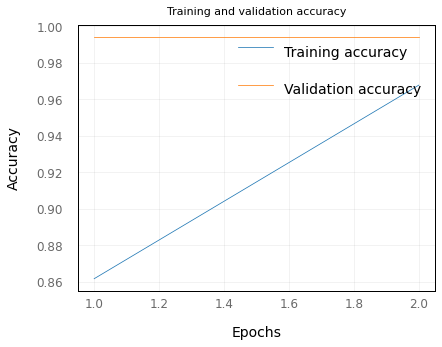

In [ ]:
accuracy = model_info_2.history['accuracy']
val_accuracy = model_info_2.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Save the model

In [ ]:
model_1.save(filepath="/content/drive/MyDrive/jigsaw-saved-models")

In [ ]:
model_2.save(filepath="/content/drive/MyDrive/jigsaw-saved-model-2")

## Model Loading

In [ ]:
loaded_model_1 = keras.models.load_model(filepath="/content/drive/MyDrive/jigsaw-saved-models/")

In [ ]:
loaded_model_2 = keras.models.load_model(filepath="/content/drive/MyDrive/jigsaw-saved-model-2")

In [ ]:
# Examining the developed Model
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    prediction = model_1.predict(new_string) #(Change to model_1 or model_2 depending on the preference of model type|| Model 1: LSTM, Model 2:LSTM-CNN)
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    return

In [ ]:
from sklearn.model_selection import train_test_split
X = train["comment_text"].values
y = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Divide the data into test and train sets.

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train.tolist())
train_sequences = tokenizer.texts_to_sequences(X_train.tolist())
test_sequences = tokenizer.texts_to_sequences(X_test.tolist())
X_train = pad_sequences(train_sequences, maxlen=maxpadlen)
X_test = pad_sequences(test_sequences, maxlen=maxpadlen)

In [ ]:
# Model Evaluate
model_1.evaluate(X_test, y_test)

998/998 [==============================] - 5s 5ms/step - loss: 0.2271 - accuracy: 0.9892


[0.22712567448616028, 0.9891900420188904]

In [ ]:
# Model Evaluate
model_2.evaluate(X_test, y_test)

998/998 [==============================] - 5s 5ms/step - loss: 0.2101 - accuracy: 0.9941


[0.21013586223125458, 0.9941093325614929]

In [ ]:
test_label_df = pd.read_csv('test_labels.csv')

In [ ]:
merged_data = test.merge(test_label_df, on='id')  # Using the 'id' column as a guide, merge the two DataFrames.
merged_data = merged_data[(merged_data["toxic"] != -1) &
                          (merged_data["severe_toxic"] != -1) &
                          (merged_data["obscene"] != -1) &
                          (merged_data["threat"] != -1) &
                          (merged_data["insult"] != -1) &
                          (merged_data["identity_hate"] != -1)] # Eliminate the rows whose labels indicate that they were not utilized for scoring (rows with a -1).
print(merged_data.head())

                  id                                       comment_text  \
5   0001ea8717f6de06  thank you for understanding i think very highl...   
7   000247e83dcc1211                    dear god this site is horrible    
11  0002f87b16116a7f   somebody will invariably try to add religion ...   
13  0003e1cccfd5a40a   it says it right there that it is a type the ...   
14  00059ace3e3e9a53   before adding a new product to the list make ...   

    toxic  severe_toxic  obscene  threat  insult  identity_hate  
5       0             0        0       0       0              0  
7       0             0        0       0       0              0  
11      0             0        0       0       0              0  
13      0             0        0       0       0              0  
14      0             0        0       0       0              0  


In [ ]:
test_sequences = tokenizer.texts_to_sequences(merged_data['comment_text'])
X_test = pad_sequences(test_sequences, maxlen=maxpadlen)  # Extract the actual labels from the combined data. InfoFrame
y_test = merged_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_pred_proba = model_2.predict(X_test)  # Use the learned LSTM model to predict the labels.
y_pred = y_pred_proba > 0.5 # The threshold value can be changed to suit your needs.

2000/2000 [==============================] - 8s 4ms/step


In [ ]:
from sklearn.metrics import f1_score, accuracy_score  # Compute evaluation measures, such as accuracy, F1 score, etc.
f1_micro = f1_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)
print(f"F1 micro score: {f1_micro}")
print(f"Accuracy: {accuracy}")

F1 micro score: 0.0113801605867105
Accuracy: 0.885429366344681


In [ ]:
toxicity_level('i dont agree with your point of view, but i respect your opinion')

1/1 [==============================] - 0s 42ms/step
Toxicity levels for 'i dont agree with your point of view, but i respect your opinion':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level('i will kill you')

1/1 [==============================] - 0s 28ms/step
Toxicity levels for 'i will kill you':
Toxic:         28%
Severe Toxic:  1%
Obscene:       8%
Threat:        4%
Insult:        7%
Identity Hate: 2%



In [ ]:
toxicity_level('have a nice day')

1/1 [==============================] - 0s 37ms/step
Toxicity levels for 'have a nice day':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level('fuck ofF!!')

1/1 [==============================] - 0s 35ms/step
Toxicity levels for 'fuck ofF!!':
Toxic:         99%
Severe Toxic:  20%
Obscene:       97%
Threat:        2%
Insult:        73%
Identity Hate: 1%



In [ ]:
toxicity_level('Hello, How are you?')

1/1 [==============================] - 0s 42ms/step
Toxicity levels for 'Hello, How are you?':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [ ]:
toxicity_level('get the fuck away from me @sshole!!')

1/1 [==============================] - 0s 26ms/step
Toxicity levels for 'get the fuck away from me @sshole!!':
Toxic:         98%
Severe Toxic:  10%
Obscene:       93%
Threat:        3%
Insult:        63%
Identity Hate: 1%



In [ ]:
toxicity_level("I can't believe how rude and obnoxious that person was to me")

1/1 [==============================] - 0s 32ms/step
Toxicity levels for 'I can't believe how rude and obnoxious that person was to me':
Toxic:         3%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

